# Analisis Data Time Series

Data time series adalah sekumpulan observasi yang direkam berdasarkan urutan waktu, biasanya dengan interval yang tetap (misalnya per jam, per hari, per bulan, dan sebagainya).  
Contohnya seperti:
- Harga saham harian,
- Suhu udara per jam,
- Jumlah penjualan mingguan,
- Nilai sensor yang dicatat per detik.

Dalam konteks analisis ini, saya menggunakan data time series yang kemudian akan diubah menjadi supervised learning, sehingga model seperti KNN Regression dapat melakukan prediksi terhadap nilai masa depan.

Data diambil berdasarkan panduan dari dokumentasi resmi OpenEO:
> https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NO2Covid.html

Referensi ini digunakan sebagai dasar untuk mempelajari cara melakukan koneksi API dan pemrosesan data Sentinel-5P.

## Analisis Data Time Series Kadar Polutan NO₂ Daerah Kabupaten Nganjuk Tahun 2022-2025
Studi ini menganalisis konsentrasi rata-rata gas NO₂ di wilayah Kabupaten Nganjuk selama periode Mei 2022 hingga Mei 2025.  
Konsentrasi NO₂ digunakan sebagai indikator tingkat polusi udara dari aktivitas kendaraan dan industri.

Link berikut digunakan untuk menentukan area koordinat (AOI – Area of Interest) menggunakan format GeoJSON:
> https://geojson.io/#map=9.85/-7.6152/111.9468

Dengan alat ini, pengguna dapat menggambar area batas Kabupaten Nganjuk secara manual dan menyalin koordinatnya ke dalam kode.


### Instalasi library OpenEO
Perintah berikut digunakan untuk memasang pustaka `openeo` agar dapat mengakses API OpenEO.


In [1]:
pip install openeo

Note: you may need to restart the kernel to use updated packages.


### Crawling dataset
Langkah berikut digunakan untuk mengakses dataset satelit Sentinel-5P melalui API OpenEO.

In [2]:
import openeo

#### Menghubungkan ke API OpenEO
Melakukan autentikasi menggunakan metode OIDC agar bisa mengakses dataset Copernicus Data Space.




In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

#### Menentukan Area of Interest (AOI)
Area yang dipilih adalah **Kabupaten Nganjuk, Jawa Timur**, dengan batas koordinat geografis (longitude dan latitude) dalam format poligon.

In [4]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [111.6, -7.4],   # barat laut (Kec. Sawahan)
            [111.6, -7.9],   # barat daya (Pace/Loceret)
            [112.3, -7.9],   # tenggara (Prambon)
            [112.3, -7.4],   # timur laut (Rejoso)
            [111.6, -7.4],   # kembali ke titik awal
        ]
    ],
}

#### Memuat Koleksi Sentinel-5P
Data yang diambil adalah **band NO₂** dari koleksi `SENTINEL_5P_L2` dengan rentang waktu 2022–2025.

In [5]:
# Load koleksi Sentinel-5P NO₂
s5_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-05-01", "2025-05-31"],
    spatial_extent={
        "west": 111.6,
        "south": -7.9,
        "east": 112.3,
        "north": -7.4,
    },
    bands=["NO2"],
)

#### Agregasi Temporal dan Spasial
- `aggregate_temporal_period`: Menghitung rata-rata nilai NO₂ per hari.
- `aggregate_spatial`: Mengambil rata-rata spasial untuk area poligon Nganjuk.

In [6]:
# Agregasi temporal per hari
s5_no2_daily = s5_no2.aggregate_temporal_period(
    reducer="mean",
    period="day"
)

# Agregasi spasial berdasarkan area poligon
s5_no2_mean = s5_no2_daily.aggregate_spatial(
    reducer="mean",
    geometries=aoi
)



#### Monitoring Eksekusi Job
Status job dan log dapat dipantau menggunakan `job.status()` dan `job.logs()` untuk mengetahui hasil dan error yang terjadi.

In [11]:
# Eksekusi batch job
job = s5_no2_mean.execute_batch(
    title="NO2_2022_2025_Blitar",
    outputfile="no2_blitar_2022_2025.geojson"
)

# Tampilkan status job dan log
print("Status job:", job.status())
print("Menampilkan log eksekusi:")
print(job.logs())

0:00:00 Job 'j-251022031910428bb6db810a5566239c': send 'start'
0:00:13 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:18 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:25 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:33 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:43 Job 'j-251022031910428bb6db810a5566239c': created (progress 0%)
0:00:56 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:01:12 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:01:31 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:01:55 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:02:26 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:03:03 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:03:50 Job 'j-251022031910428bb6db810a5566239c': running (progress N/A)
0:04:49 Job 'j-251022031910428bb6db810a5566239c': running (progres

#### Menyimpan Hasil
Data hasil agregasi disimpan dalam format `.csv` agar mudah diproses pada tahap analisis berikutnya.

In [7]:
# Eksekusi batch job dan hasilkan file CSV
job = s5_no2_mean.execute_batch(
    title="NO2_2022_2025_Nganjuk",
    outputfile="no2_nganjuk_2022_2025.csv",  # hasil akhir dalam CSV
    format="CSV"  # format output eksplisit
)

# Tampilkan status job dan log
print("Status job:", job.status())
print("Menampilkan log eksekusi:")
print(job.logs())

0:00:00 Job 'j-2510220400594bf68c6e5c0ac6f24d98': send 'start'
0:00:13 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:19 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:25 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:33 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:44 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:00:56 Job 'j-2510220400594bf68c6e5c0ac6f24d98': queued (progress 0%)
0:01:12 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:01:31 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:01:56 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:02:26 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:03:04 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:03:51 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)
0:04:49 Job 'j-2510220400594bf68c6e5c0ac6f24d98': running (progress N/A)


### Informasi dataset
Setelah data berhasil diekstrak dari OpenEO, file CSV dimuat ke dalam notebook menggunakan Pandas.
Pada tahap ini kita akan melihat:
- Struktur dataset
- Jumlah data dan kolom
- Cuplikan beberapa baris awal

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca dataset
data = pd.read_csv("no2_nganjuk_2022_2025.csv")

# Menampilkan 10 baris pertama
print("📊 Contoh Data Awal:")
print(data.head(10))

# Informasi dataset
print("\n📋 Informasi Dataset:")
print(data.info())



📊 Contoh Data Awal:
                       date  feature_index       NO2
0  2022-07-03T00:00:00.000Z              0  0.000029
1  2022-07-08T00:00:00.000Z              0  0.000024
2  2022-07-07T00:00:00.000Z              0  0.000024
3  2022-07-06T00:00:00.000Z              0       NaN
4  2022-07-04T00:00:00.000Z              0  0.000042
5  2022-07-05T00:00:00.000Z              0  0.000030
6  2022-07-09T00:00:00.000Z              0  0.000032
7  2022-07-10T00:00:00.000Z              0  0.000026
8  2022-10-12T00:00:00.000Z              0  0.000024
9  2022-10-09T00:00:00.000Z              0  0.000023

📋 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1127 non-null   object 
 1   feature_index  1127 non-null   int64  
 2   NO2            946 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory us

### Eksplorasi dan Visualisasi Awal
Sebelum melakukan preprocessing, dilakukan eksplorasi awal untuk:
- Melihat sebaran nilai NO₂ per tanggal
- Mengecek missing values
- Mengamati tren musiman atau pola fluktuasi
Visualisasi ini membantu memahami kondisi awal dataset sebelum dilakukan transformasi lebih lanjut.



📈 Statistik Deskriptif:
       feature_index         NO2
count         1127.0  946.000000
mean             0.0    0.000027
std              0.0    0.000008
min              0.0   -0.000009
25%              0.0    0.000022
50%              0.0    0.000027
75%              0.0    0.000032
max              0.0    0.000067

🕳️ Jumlah Missing Values Tiap Kolom:
date               0
feature_index      0
NO2              181
dtype: int64


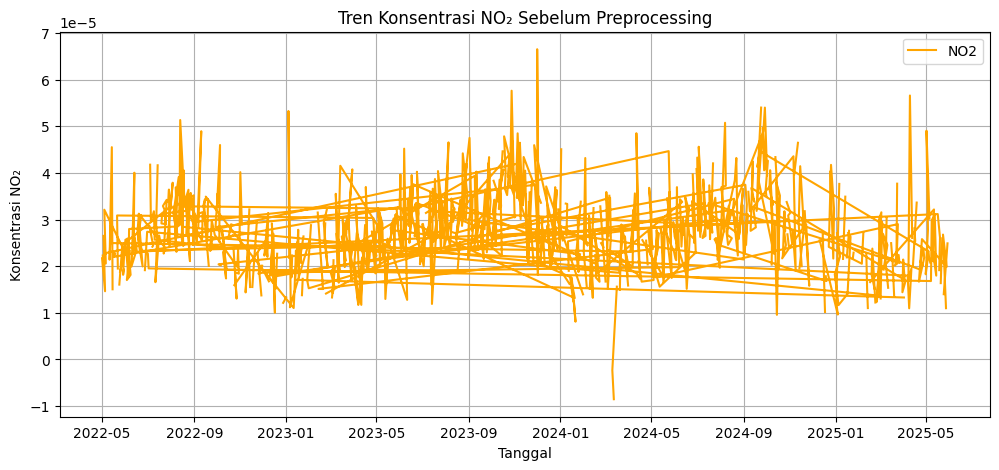

In [4]:
# Statistik deskriptif
print("\n📈 Statistik Deskriptif:")
print(data.describe())

# Cek missing values
print("\n🕳️ Jumlah Missing Values Tiap Kolom:")
print(data.isnull().sum())


# Visualisasi tren data (misal kolom 'NO2')
plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(data['date']), data['NO2'], label='NO2', color='orange')
plt.title('Tren Konsentrasi NO₂ Sebelum Preprocessing')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂')
plt.legend()
plt.grid(True)
plt.show()

### Preprocessing data
Tahapan preprocessing meliputi:
1. **Pengecekan dan penanganan missing values**  \
   Menghapus atau mengisi data yang hilang agar model tidak bias.
2. **Pembersihan data anomali/outlier** \
   Menangani nilai ekstrem yang mungkin muncul akibat kesalahan sensor.
3. **Konversi format tanggal** \
   Memastikan kolom tanggal diubah menjadi format `datetime` agar bisa diolah sebagai time series.


🔧 Tahap Preprocessing:

✅ Data setelah preprocessing:
                       date  feature_index       NO2
0 2022-05-01 00:00:00+00:00              0  0.000022
1 2022-05-02 00:00:00+00:00              0  0.000022
2 2022-05-03 00:00:00+00:00              0  0.000027
3 2022-05-04 00:00:00+00:00              0  0.000032
4 2022-05-05 00:00:00+00:00              0  0.000015


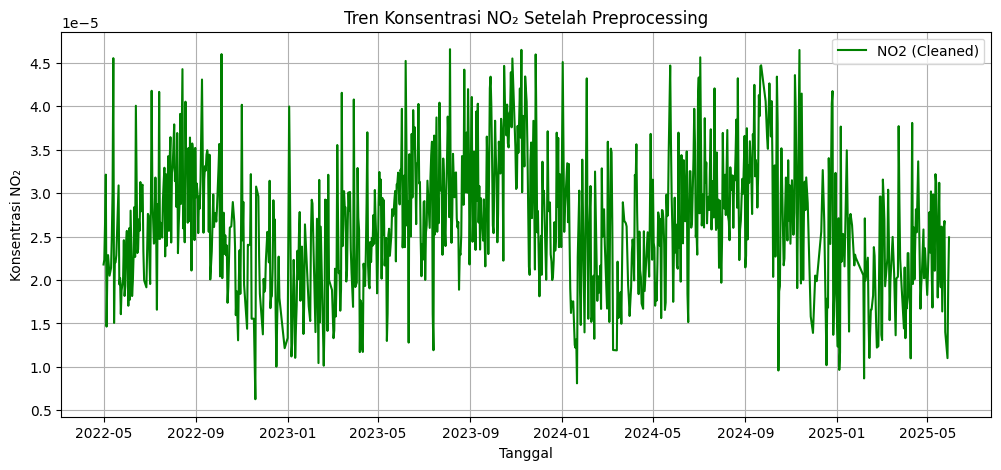


💾 File hasil preprocessing disimpan sebagai: hasil_preprocessing.csv


In [23]:
print("\n🔧 Tahap Preprocessing:")

# 1. Ubah kolom tanggal menjadi datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# 2. Hapus baris dengan tanggal tidak valid
data = data.dropna(subset=['date'])

# 3. Sortir berdasarkan tanggal
data = data.sort_values(by='date').reset_index(drop=True)

# 4. Isi nilai hilang (missing values) pada kolom NO2 dengan interpolasi linear
if 'NO2' in data.columns:
    data['NO2'] = data['NO2'].interpolate(method='linear')

# 5. Hapus outlier dengan metode IQR
q1 = data['NO2'].quantile(0.25)
q3 = data['NO2'].quantile(0.75)
iqr = q3 - q1
batas_bawah = q1 - 1.5 * iqr
batas_atas = q3 + 1.5 * iqr
data = data[(data['NO2'] >= batas_bawah) & (data['NO2'] <= batas_atas)]

# 6. Cek hasil akhir
print("\n✅ Data setelah preprocessing:")
print(data.head())

# Visualisasi setelah preprocessing
plt.figure(figsize=(12, 5))
plt.plot(data['date'], data['NO2'], label='NO2 (Cleaned)', color='green')
plt.title('Tren Konsentrasi NO₂ Setelah Preprocessing')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂')
plt.legend()
plt.grid(True)
plt.show()

# 7. Simpan hasil preprocessing
data.to_csv("hasil_preprocessing.csv", index=False)
print("\n💾 File hasil preprocessing disimpan sebagai: hasil_preprocessing.csv")


### Transformasi Time Series ke Supervised Learning
Data time series diubah ke bentuk supervised agar bisa digunakan oleh model regresi seperti KNN.  
Contoh transformasi:
| t-2 | t-1 | t |
|-----|-----|---|
| 10  | 12  | 15 |

Artinya, nilai hari ke-t diprediksi berdasarkan dua hari sebelumnya.


In [24]:
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):  # input lag
        cols.append(df.shift(i))
    for i in range(0, n_out):      # output target
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg

# Mengubah data menjadi format supervised (lag 1)
supervised_data = series_to_supervised(data['NO2'], n_in=1, n_out=1)
supervised_data.columns = ['NO2(t-1)', 'NO2(t)']

print("\n🔁 Contoh Data Supervised Learning:")
print(supervised_data.head())

# Simpan hasil supervised learning
supervised_data.to_csv("hasil_supervised.csv", index=False)
print("\n💾 File hasil supervised learning disimpan sebagai: hasil_supervised.csv")



🔁 Contoh Data Supervised Learning:
   NO2(t-1)    NO2(t)
1  0.000022  0.000022
2  0.000022  0.000027
3  0.000027  0.000032
4  0.000032  0.000015
5  0.000015  0.000021

💾 File hasil supervised learning disimpan sebagai: hasil_supervised.csv


### Normalisasi Data
Normalisasi digunakan agar semua fitur memiliki skala yang seragam.
Terdapat dua metode utama:
- **Min-Max Scaling** → mengubah nilai ke rentang [0, 1]
- **Z-Score Standardization** → menormalkan berdasarkan distribusi rata-rata dan deviasi standar

Normalisasi penting untuk model KNN karena jarak antar titik sangat bergantung pada skala fitur.



💾 File hasil normalisasi disimpan sebagai:
- hasil_normalisasi_minmax.csv
- hasil_normalisasi_zscore.csv


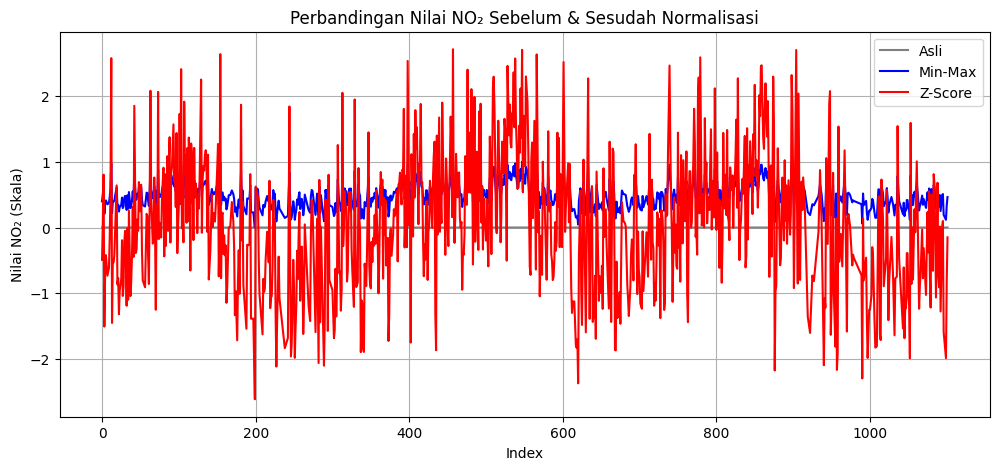

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# --- Normalisasi Min-Max ---
minmax_scaler = MinMaxScaler()
scaled_minmax = pd.DataFrame(minmax_scaler.fit_transform(supervised_data),
                             columns=supervised_data.columns)

# --- Normalisasi Z-Score ---
zscore_scaler = StandardScaler()
scaled_zscore = pd.DataFrame(zscore_scaler.fit_transform(supervised_data),
                             columns=supervised_data.columns)

# Simpan hasil normalisasi
scaled_minmax.to_csv("hasil_normalisasi_minmax.csv", index=False)
scaled_zscore.to_csv("hasil_normalisasi_zscore.csv", index=False)

print("\n💾 File hasil normalisasi disimpan sebagai:")
print("- hasil_normalisasi_minmax.csv")
print("- hasil_normalisasi_zscore.csv")

# Visualisasi perbandingan sebelum & sesudah normalisasi
plt.figure(figsize=(12, 5))
plt.plot(supervised_data['NO2(t)'].values, label='Asli', color='gray')
plt.plot(scaled_minmax['NO2(t)'].values, label='Min-Max', color='blue')
plt.plot(scaled_zscore['NO2(t)'].values, label='Z-Score', color='red')
plt.title('Perbandingan Nilai NO₂ Sebelum & Sesudah Normalisasi')
plt.xlabel('Index')
plt.ylabel('Nilai NO₂ (Skala)')
plt.legend()
plt.grid(True)
plt.show()


### Model KNN Regression
Setelah data siap, dilakukan eksperimen menggunakan **K-Nearest Neighbors Regression**.
- Model ini bekerja dengan mencari *k* tetangga terdekat untuk memprediksi nilai baru.
- Digunakan untuk memprediksi kadar NO₂ hari berikutnya berdasarkan pola historis.

Eksperimen dilakukan dengan mencoba beberapa variasi:
- Jumlah lag berbeda (misalnya 1, 3, 7 hari)
- Nilai `k` berbeda untuk model KNN
Tujuannya adalah untuk mengetahui **berapa lag optimal** yang paling memengaruhi hasil prediksi.


#### Import dan Persiapan Data

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Baca data hasil preprocessing
data = pd.read_csv("hasil_preprocessing.csv")

# Pastikan urutan tanggal benar
data = data.sort_values(by='date').reset_index(drop=True)

# Ambil kolom NO2
values = data['NO2'].values


#### Fungsi untuk Mengubah Data ke Bentuk Supervised Learning

In [6]:
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg


### Evaluasi Model
Evaluasi dilakukan dengan metrik seperti:
- **MAE (Mean Absolute Error)**
- **RMSE (Root Mean Square Error)**
- **R² Score**

In [29]:
lags = [1, 3, 5, 7, 10]  # jumlah lag yang akan diuji
results = []

for lag in lags:
    supervised = series_to_supervised(values, n_in=lag, n_out=1)
    supervised.columns = [f"NO2(t-{i})" for i in range(lag, 0, -1)] + ["NO2(t)"]

    # Pisahkan fitur dan target
    X = supervised.iloc[:, :-1].values
    y = supervised.iloc[:, -1].values

    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # Buat dan latih model KNN Regression
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Evaluasi
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Lag": lag,
        "RMSE": rmse,
        "MAE": mae,
        "R2_Score": r2
    })

# Hasil ke DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Hasil Evaluasi KNN Regression per Lag:")
print(results_df)



📊 Hasil Evaluasi KNN Regression per Lag:
   Lag      RMSE       MAE  R2_Score
0    1  0.000007  0.000005 -0.006075
1    3  0.000007  0.000005 -0.091798
2    5  0.000007  0.000005  0.049690
3    7  0.000007  0.000005 -0.014179
4   10  0.000007  0.000006 -0.074595


#### Visualisasi Perbandingan Performa Antar Lag

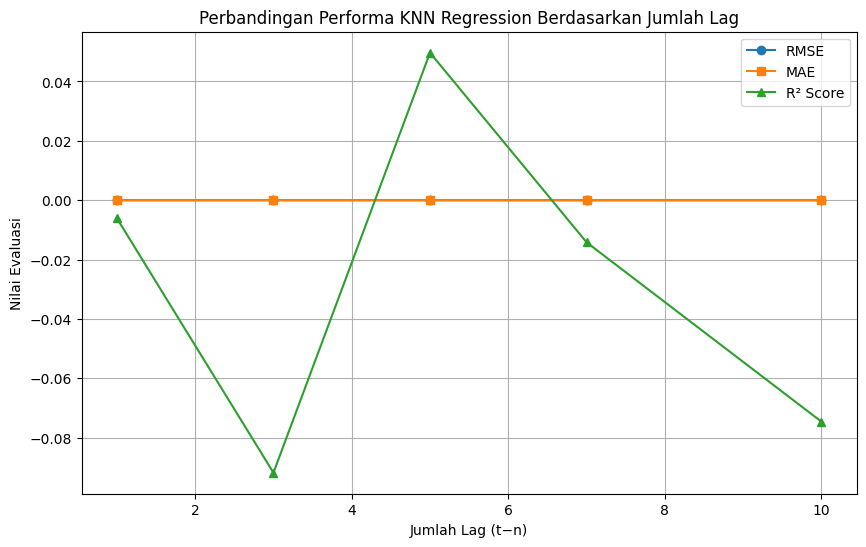

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(results_df["Lag"], results_df["RMSE"], marker='o', label='RMSE')
plt.plot(results_df["Lag"], results_df["MAE"], marker='s', label='MAE')
plt.plot(results_df["Lag"], results_df["R2_Score"], marker='^', label='R² Score')

plt.title("Perbandingan Performa KNN Regression Berdasarkan Jumlah Lag")
plt.xlabel("Jumlah Lag (t−n)")
plt.ylabel("Nilai Evaluasi")
plt.legend()
plt.grid(True)
plt.show()


Analisis:

- Jika R² naik dan RMSE turun → lag lebih tinggi memberi konteks yang baik.
- Jika R² turun setelah titik tertentu → informasi lama mulai tidak relevan.
- Lag optimal bisa ditentukan dengan nilai R² tertinggi dan RMSE terendah.